<a href="https://colab.research.google.com/github/rphuong/birds/blob/main/Phuong_Bird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Bird? The Code
Here are the functions I used throughout the project. The experiments can also be seen below. 

## Main Code
First, I imported related libraries and switched the device to GPU if possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Next, I modified the `get_data` function from the tutorial to have all the extra data augmentation I described. 

In [2]:
def get_data(size):
  transform_train = transforms.Compose([
    transforms.ColorJitter(0.5, 0.5, 0.5, 0),
    transforms.RandomRotation(15),
    transforms.RandomCrop(size, padding=8, padding_mode='edge'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  trainset = torchvision.datasets.ImageFolder('./birds%d/train' % size, transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder('./birds%d/test' % size, transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=2)

  class_to_idx = trainset.class_to_idx
  idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
  return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class}

In [50]:
data = get_data(128)

I created 2 separate network models. The first only changes the final layer. The second changes the final layer as well as adds a dropout layer. After preparing these networks, I froze the weights for the first 7 layers. 

In [3]:
def get_net():
  net = torchvision.models.resnet18(pretrained=True)
  net.fc = nn.Linear(net.fc.in_features, 555)
  return net

In [11]:
net = get_net()

i = 0
for child in net.children():
  for param in child.parameters():
      param.requires_grad = False
  i += 1
  if i == 7:
    break

In [3]:
def get_drop_net():
  net = torchvision.models.resnet18(pretrained=True)
  net.fc = nn.Sequential(
    nn.Dropout2d(),
    nn.Linear(net.fc.in_features, 555)
  )
  return net

In [ ]:
net = get_drop_net()

i = 0
for child in net.children():
  for param in child.parameters():
      param.requires_grad = False
  i += 1
  if i == 7:
    break

The training function stayed relatively the same as the tutorial except I made sure to only train the required weights.

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), 
                          lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

Below are the `smooth`, `accuracy`, and `predict` functions related to viewing results and creating the Kaggle submission. 

In [6]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [6]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for i, (images, labels) in enumerate(dataloader, 0):
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [12]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%1000 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data2['to_class'][predicted.item()]))
    out.close()

Finally, I needed to actually load the pre-resized data onto the Colab runtime and setup the directory that I would like any created files to be located. 

In [ ]:
! unzip drive/MyDrive/kaggle/birds128.zip
! unzip drive/MyDrive/kaggle/birds224.zip

In [7]:
import os
checkpoints = '/content/drive/MyDrive/kaggle/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

## Experiments
I first attempted to train network on a set schedule. It was split into two cells because the runtime disconnected. 

This resulted in a testing accuracy of only 54%

In [ ]:
dir = checkpoints + 'init_pts/'
if not os.path.exists(dir):
    os.makedirs(dir)
losses = train(net, data['train'], epochs=20, schedule={0:.1, 10:.01, 15:.001}, checkpoint_path=dir)

Learning rate: 0.100000
[0,    10] loss: 6.556
[0,    20] loss: 6.295
[0,    30] loss: 5.809
[0,    40] loss: 5.373
[0,    50] loss: 5.066
[0,    60] loss: 4.730
[0,    70] loss: 4.596
[0,    80] loss: 4.399
[0,    90] loss: 4.187
[0,   100] loss: 4.021
[0,   110] loss: 3.862
[0,   120] loss: 3.753
[0,   130] loss: 3.686
[0,   140] loss: 3.508
[0,   150] loss: 3.483
[0,   160] loss: 3.570
[0,   170] loss: 3.399
[0,   180] loss: 3.394
[0,   190] loss: 3.371
[0,   200] loss: 3.213
[0,   210] loss: 3.238
[0,   220] loss: 3.181
[0,   230] loss: 3.160
[0,   240] loss: 3.089
[0,   250] loss: 2.977
[0,   260] loss: 3.123
[0,   270] loss: 3.148
[0,   280] loss: 3.040
[0,   290] loss: 3.058
[0,   300] loss: 3.159
[1,    10] loss: 2.666
[1,    20] loss: 2.578
[1,    30] loss: 2.527
[1,    40] loss: 2.571
[1,    50] loss: 2.412
[1,    60] loss: 2.449
[1,    70] loss: 2.440
[1,    80] loss: 2.470
[1,    90] loss: 2.467
[1,   100] loss: 2.519
[1,   110] loss: 2.559
[1,   120] loss: 2.477
[1,   130]

In [ ]:
state = torch.load(checkpoints + 'init_pts/checkpoint-17.pkl')
pretrain_net = get_net()
pretrain_net.load_state_dict(state['net'])

In [ ]:
dir = checkpoints + 'init_pts/'
if not os.path.exists(dir):
    os.makedirs(dir)
losses = train(pretrain_net, data['train'], epochs=25, schedule={0:.1, 10:.01, 15:.001, 20:.0001}, checkpoint_path=dir, start_epoch=17)

Learning rate: 0.100000
Learning rate: 0.010000
Learning rate: 0.001000
[17,    10] loss: 1.001
[17,    20] loss: 1.054
[17,    30] loss: 1.026
[17,    40] loss: 1.025
[17,    50] loss: 1.002
[17,    60] loss: 1.055
[17,    70] loss: 1.038
[17,    80] loss: 1.008
[17,    90] loss: 0.995
[17,   100] loss: 0.993
[17,   110] loss: 1.034
[17,   120] loss: 1.023
[17,   130] loss: 1.010
[17,   140] loss: 1.066
[17,   150] loss: 1.015
[17,   160] loss: 0.978
[17,   170] loss: 1.068
[17,   180] loss: 1.014
[17,   190] loss: 1.071
[17,   200] loss: 0.969
[17,   210] loss: 1.018
[17,   220] loss: 1.015
[17,   230] loss: 1.048
[17,   240] loss: 1.023
[17,   250] loss: 0.944
[17,   260] loss: 1.083
[17,   270] loss: 1.069
[17,   280] loss: 0.964
[17,   290] loss: 1.031
[17,   300] loss: 1.032
[18,    10] loss: 0.967
[18,    20] loss: 1.022
[18,    30] loss: 1.008
[18,    40] loss: 1.032
[18,    50] loss: 1.071
[18,    60] loss: 1.002
[18,    70] loss: 1.046
[18,    80] loss: 0.985
[18,    90] loss

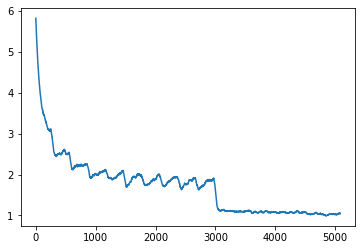

In [ ]:
state2 = torch.load(checkpoints + 'init_pts/checkpoint-17.pkl')
pretrain_net = get_net()
pretrain_net.load_state_dict(state2['net'])
plt.plot(smooth(state2['losses'],50))

In [ ]:
data = get_data(224)
print("Training accuracy: %f" % accuracy(pretrain_net, data['train']))

Training accuracy: 0.761457


Then I tried to freeze the parameters by providing only the fc parameters to the optimizer. There seemed to be no difference although I did notice the training accuracy was 78% while testing accuracy on Kaggle was only 54%. It seems that it is overfitting, which I knew would be a problem I would have to address later.

In [ ]:
freeze_net = get_net().to(device)
dir = checkpoints + 'freeze_pts/'
if not os.path.exists(dir):
    os.makedirs(dir)
losses = train(freeze_net, data['train'], epochs=25, schedule={0:.1, 10:.01, 15:.001, 20:.0001}, checkpoint_path=dir)

Learning rate: 0.100000
[0,    10] loss: 6.495
[0,    20] loss: 6.198
[0,    30] loss: 5.700
[0,    40] loss: 5.405
[0,    50] loss: 5.079
[0,    60] loss: 4.739
[0,    70] loss: 4.632
[0,    80] loss: 4.249
[0,    90] loss: 4.164
[0,   100] loss: 4.097
[0,   110] loss: 3.935
[0,   120] loss: 3.807
[0,   130] loss: 3.794
[0,   140] loss: 3.611
[0,   150] loss: 3.442
[0,   160] loss: 3.543
[0,   170] loss: 3.477
[0,   180] loss: 3.388
[0,   190] loss: 3.259
[0,   200] loss: 3.299
[0,   210] loss: 3.321
[0,   220] loss: 3.143
[0,   230] loss: 3.184
[0,   240] loss: 3.179
[0,   250] loss: 3.138
[0,   260] loss: 3.110
[0,   270] loss: 3.065
[0,   280] loss: 2.995
[0,   290] loss: 3.034
[0,   300] loss: 3.050
[1,    10] loss: 2.780
[1,    20] loss: 2.557
[1,    30] loss: 2.464
[1,    40] loss: 2.576
[1,    50] loss: 2.354
[1,    60] loss: 2.384
[1,    70] loss: 2.418
[1,    80] loss: 2.467
[1,    90] loss: 2.451
[1,   100] loss: 2.442
[1,   110] loss: 2.407
[1,   120] loss: 2.510
[1,   130]

In [ ]:
print("Training accuracy: %f" % accuracy(pretrainfreeze_net, data['train']))


0
Training accuracy: 0.782143


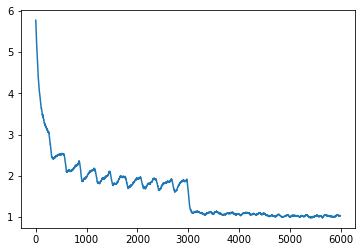

In [ ]:
state = torch.load(checkpoints + 'freeze_pts/checkpoint-20.pkl')
pretrainfreeze_net = get_net()
pretrainfreeze_net.load_state_dict(state['net'])
plt.plot(smooth(state['losses'],50))

### Beginning to Unfreeze
I decided to only freeze the first few parts so the last parts can be trained for the bird dataset. Below you can see the various layers of ResNet18. I decided to freeze all the convolutional layers except those belonging to the last Sequential section.

In [ ]:
net = get_net()

i = 0
for child in net.children():
   print(str(i) + ":")
   print(child)
   i += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



0:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2:
ReLU(inplace=True)
3:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

### Finding the best learning rate

I first started with the 128 pixel data set. I tested out various learning rates around the 0.1 but found that as I decreased to 0.03, the losses were much steeper. Thus, I began to use 0.3 as my starting learning rate.

[0,    10] loss: 6.569
[0,    20] loss: 6.437
[0,    30] loss: 5.982
[0,    40] loss: 5.734
[0,    50] loss: 5.555
[0,    60] loss: 5.165
[0,    70] loss: 5.175
[0,    80] loss: 4.745
[0,    90] loss: 4.515
[0,   100] loss: 4.506
[0,   110] loss: 4.309
[0,   120] loss: 4.211
[0,   130] loss: 4.067
[0,   140] loss: 4.050
[0,   150] loss: 4.072
[0,   160] loss: 3.940
[0,   170] loss: 3.763
[0,   180] loss: 3.693
[0,   190] loss: 3.751
[0,   200] loss: 3.648
[0,   210] loss: 3.564
[0,   220] loss: 3.610
[0,   230] loss: 3.454
[0,   240] loss: 3.306
[0,   250] loss: 3.426
[0,   260] loss: 3.382
[0,   270] loss: 3.405
[0,   280] loss: 3.260
[0,   290] loss: 3.228
[0,   300] loss: 3.259


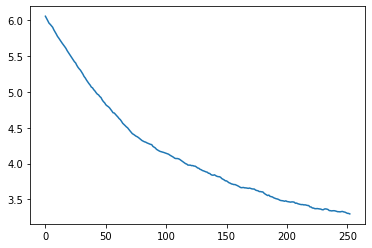

In [ ]:
losses = train(net, data['train'], lr=0.12)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.541
[0,    20] loss: 6.141
[0,    30] loss: 5.709
[0,    40] loss: 5.738
[0,    50] loss: 5.218
[0,    60] loss: 5.260
[0,    70] loss: 4.944
[0,    80] loss: 4.897
[0,    90] loss: 4.626
[0,   100] loss: 4.555
[0,   110] loss: 4.319
[0,   120] loss: 4.236
[0,   130] loss: 3.944
[0,   140] loss: 4.026
[0,   150] loss: 3.941
[0,   160] loss: 3.913
[0,   170] loss: 3.749
[0,   180] loss: 3.758
[0,   190] loss: 3.711
[0,   200] loss: 3.617
[0,   210] loss: 3.670
[0,   220] loss: 3.419
[0,   230] loss: 3.459
[0,   240] loss: 3.412
[0,   250] loss: 3.381
[0,   260] loss: 3.434
[0,   270] loss: 3.235
[0,   280] loss: 3.315
[0,   290] loss: 3.146
[0,   300] loss: 3.184


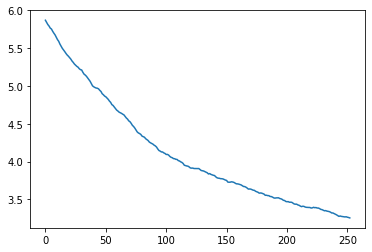

In [ ]:
losses = train(net, data['train'], lr=0.1)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.504
[0,    20] loss: 6.124
[0,    30] loss: 5.647
[0,    40] loss: 5.412
[0,    50] loss: 5.100
[0,    60] loss: 4.939
[0,    70] loss: 4.803
[0,    80] loss: 4.601
[0,    90] loss: 4.459
[0,   100] loss: 4.280
[0,   110] loss: 4.232
[0,   120] loss: 4.139
[0,   130] loss: 3.998
[0,   140] loss: 4.015
[0,   150] loss: 3.847
[0,   160] loss: 3.810
[0,   170] loss: 3.756
[0,   180] loss: 3.778
[0,   190] loss: 3.620
[0,   200] loss: 3.490
[0,   210] loss: 3.503
[0,   220] loss: 3.521
[0,   230] loss: 3.503
[0,   240] loss: 3.414
[0,   250] loss: 3.430
[0,   260] loss: 3.507
[0,   270] loss: 3.256
[0,   280] loss: 3.313
[0,   290] loss: 3.165
[0,   300] loss: 3.244


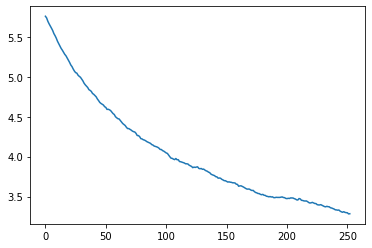

In [ ]:
losses = train(net, data['train'], lr=0.08)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.504
[0,    20] loss: 6.061
[0,    30] loss: 5.610
[0,    40] loss: 5.298
[0,    50] loss: 4.962
[0,    60] loss: 4.720
[0,    70] loss: 4.663
[0,    80] loss: 4.393
[0,    90] loss: 4.280
[0,   100] loss: 4.264
[0,   110] loss: 4.152
[0,   120] loss: 4.031
[0,   130] loss: 3.850
[0,   140] loss: 3.861
[0,   150] loss: 3.610
[0,   160] loss: 3.701
[0,   170] loss: 3.562
[0,   180] loss: 3.637
[0,   190] loss: 3.591
[0,   200] loss: 3.513
[0,   210] loss: 3.445
[0,   220] loss: 3.318
[0,   230] loss: 3.422
[0,   240] loss: 3.335
[0,   250] loss: 3.216
[0,   260] loss: 3.218
[0,   270] loss: 3.290
[0,   280] loss: 3.267
[0,   290] loss: 3.162
[0,   300] loss: 3.217


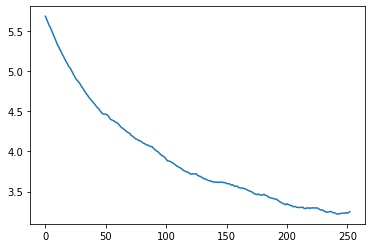

In [ ]:
losses = train(net, data['train'], lr=0.06)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.411
[0,    20] loss: 6.102
[0,    30] loss: 5.518
[0,    40] loss: 5.210
[0,    50] loss: 4.644
[0,    60] loss: 4.521
[0,    70] loss: 4.304
[0,    80] loss: 4.201
[0,    90] loss: 4.184
[0,   100] loss: 4.014
[0,   110] loss: 4.061
[0,   120] loss: 3.825
[0,   130] loss: 3.697
[0,   140] loss: 3.650
[0,   150] loss: 3.580
[0,   160] loss: 3.711
[0,   170] loss: 3.618
[0,   180] loss: 3.679
[0,   190] loss: 3.356
[0,   200] loss: 3.480
[0,   210] loss: 3.407
[0,   220] loss: 3.393
[0,   230] loss: 3.346
[0,   240] loss: 3.194
[0,   250] loss: 3.222
[0,   260] loss: 3.323
[0,   270] loss: 3.115
[0,   280] loss: 3.142
[0,   290] loss: 3.139
[0,   300] loss: 3.122


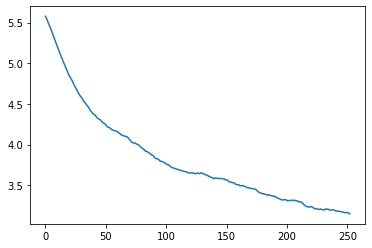

In [ ]:
losses = train(net, data['train'], lr=0.05)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.543
[0,    20] loss: 6.099
[0,    30] loss: 5.702
[0,    40] loss: 5.238
[0,    50] loss: 4.874
[0,    60] loss: 4.559
[0,    70] loss: 4.423
[0,    80] loss: 4.191
[0,    90] loss: 4.003
[0,   100] loss: 3.943
[0,   110] loss: 3.807
[0,   120] loss: 3.783
[0,   130] loss: 3.775
[0,   140] loss: 3.589
[0,   150] loss: 3.657
[0,   160] loss: 3.595
[0,   170] loss: 3.583
[0,   180] loss: 3.495
[0,   190] loss: 3.417
[0,   200] loss: 3.346
[0,   210] loss: 3.263
[0,   220] loss: 3.250
[0,   230] loss: 3.314
[0,   240] loss: 3.136
[0,   250] loss: 3.110
[0,   260] loss: 3.072
[0,   270] loss: 3.019
[0,   280] loss: 3.010
[0,   290] loss: 3.074
[0,   300] loss: 3.064


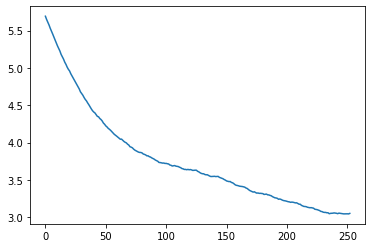

In [ ]:
losses = train(net, data['train'], lr=0.04)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.496
[0,    20] loss: 6.185
[0,    30] loss: 5.703
[0,    40] loss: 5.221
[0,    50] loss: 4.909
[0,    60] loss: 4.748
[0,    70] loss: 4.368
[0,    80] loss: 4.236
[0,    90] loss: 4.146
[0,   100] loss: 4.035
[0,   110] loss: 3.846
[0,   120] loss: 3.761
[0,   130] loss: 3.612
[0,   140] loss: 3.601
[0,   150] loss: 3.429
[0,   160] loss: 3.471
[0,   170] loss: 3.396
[0,   180] loss: 3.309
[0,   190] loss: 3.411
[0,   200] loss: 3.204
[0,   210] loss: 3.168
[0,   220] loss: 3.161
[0,   230] loss: 3.121
[0,   240] loss: 3.189
[0,   250] loss: 3.147
[0,   260] loss: 3.129
[0,   270] loss: 3.105
[0,   280] loss: 3.079
[0,   290] loss: 3.083
[0,   300] loss: 2.942


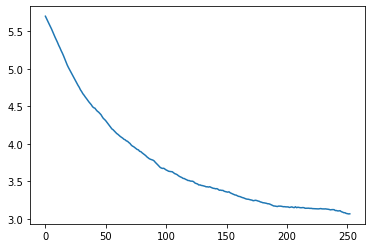

In [ ]:
losses = train(net, data['train'], lr=0.03)
plt.plot(smooth(losses,50))

[0,    10] loss: 6.553
[0,    20] loss: 6.301
[0,    30] loss: 5.977
[0,    40] loss: 5.630
[0,    50] loss: 5.394
[0,    60] loss: 5.091
[0,    70] loss: 4.833
[0,    80] loss: 4.699
[0,    90] loss: 4.368
[0,   100] loss: 4.292
[0,   110] loss: 4.250
[0,   120] loss: 4.053
[0,   130] loss: 3.995
[0,   140] loss: 3.798
[0,   150] loss: 3.745
[0,   160] loss: 3.654
[0,   170] loss: 3.640
[0,   180] loss: 3.527
[0,   190] loss: 3.523
[0,   200] loss: 3.475
[0,   210] loss: 3.547
[0,   220] loss: 3.392
[0,   230] loss: 3.366
[0,   240] loss: 3.327
[0,   250] loss: 3.303
[0,   260] loss: 3.195
[0,   270] loss: 3.283
[0,   280] loss: 3.207
[0,   290] loss: 3.067
[0,   300] loss: 3.108


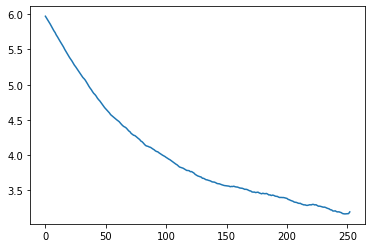

In [12]:
losses = train(net, data['train'], lr=0.02)
plt.plot(smooth(losses,50))

Here are the results after training for 10 epochs at 0.03:

In [ ]:
dir = checkpoints + '0-03_pts/'
if not os.path.exists(dir):
    os.makedirs(dir)

[0,    10] loss: 6.522
[0,    20] loss: 6.138
[0,    30] loss: 5.684
[0,    40] loss: 5.283
[0,    50] loss: 5.008
[0,    60] loss: 4.612
[0,    70] loss: 4.401
[0,    80] loss: 4.248
[0,    90] loss: 4.054
[0,   100] loss: 4.040
[0,   110] loss: 3.804
[0,   120] loss: 3.762
[0,   130] loss: 3.735
[0,   140] loss: 3.666
[0,   150] loss: 3.516
[0,   160] loss: 3.446
[0,   170] loss: 3.376
[0,   180] loss: 3.331
[0,   190] loss: 3.302
[0,   200] loss: 3.349
[0,   210] loss: 3.252
[0,   220] loss: 3.115
[0,   230] loss: 3.183
[0,   240] loss: 3.078
[0,   250] loss: 3.061
[0,   260] loss: 3.160
[0,   270] loss: 3.045
[0,   280] loss: 3.043
[0,   290] loss: 3.046
[0,   300] loss: 2.960
[1,    10] loss: 3.090
[1,    20] loss: 2.947
[1,    30] loss: 2.837
[1,    40] loss: 2.712
[1,    50] loss: 2.647
[1,    60] loss: 2.665
[1,    70] loss: 2.694
[1,    80] loss: 2.533
[1,    90] loss: 2.542
[1,   100] loss: 2.446
[1,   110] loss: 2.514
[1,   120] loss: 2.393
[1,   130] loss: 2.421
[1,   140] 

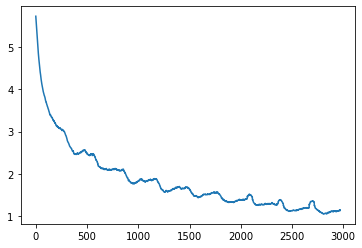

In [ ]:
losses = train(net, data['train'], lr=0.03, epochs=10, checkpoint_path=dir)
plt.plot(smooth(losses,50))

In [ ]:
print("Training accuracy: %f" % accuracy(net, data['train']))

Training accuracy: 0.763112


In [ ]:
predict(net, data['test'], checkpoints + "preds3.csv")

The testing accuracy result: 42.8%

Checking at the 5 epoch point, we see that training accuracy decreased, but testing accuracy was still 42.7%

In [ ]:
state = torch.load(checkpoints + '0-03_pts/checkpoint-5.pkl')
net.load_state_dict(state['net'])

In [ ]:
print("Training accuracy: %f" % accuracy(net, data['train']))

Training accuracy: 0.631978


In [ ]:
predict(net, data['test'], checkpoints + "preds4.csv")

### Switching data sizes
Instead of continuing at 128, I increased the training and testing size to 224. Then I trained it for 5 more epochs. The results were impressive.

In [11]:
data2 = get_data(224)

[5,    10] loss: 1.756
[5,    20] loss: 1.601
[5,    30] loss: 1.527
[5,    40] loss: 1.422
[5,    50] loss: 1.455
[5,    60] loss: 1.310
[5,    70] loss: 1.362
[5,    80] loss: 1.362
[5,    90] loss: 1.350
[5,   100] loss: 1.326
[5,   110] loss: 1.389
[5,   120] loss: 1.346
[5,   130] loss: 1.350
[5,   140] loss: 1.293
[5,   150] loss: 1.289
[5,   160] loss: 1.228
[5,   170] loss: 1.203
[5,   180] loss: 1.215
[5,   190] loss: 1.215
[5,   200] loss: 1.248
[5,   210] loss: 1.221
[5,   220] loss: 1.258
[5,   230] loss: 1.205
[5,   240] loss: 1.194
[5,   250] loss: 1.229
[5,   260] loss: 1.195
[5,   270] loss: 1.180
[5,   280] loss: 1.212
[5,   290] loss: 1.178
[5,   300] loss: 1.213
[6,    10] loss: 1.386
[6,    20] loss: 1.229
[6,    30] loss: 1.099
[6,    40] loss: 1.083
[6,    50] loss: 1.046
[6,    60] loss: 1.038
[6,    70] loss: 1.003
[6,    80] loss: 1.032
[6,    90] loss: 1.017
[6,   100] loss: 1.014
[6,   110] loss: 1.001
[6,   120] loss: 1.062
[6,   130] loss: 1.021
[6,   140] 

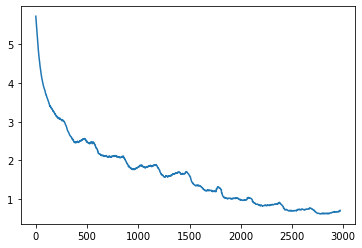

In [ ]:
dir = checkpoints + '0-03_2pts/'
if not os.path.exists(dir):
    os.makedirs(dir)
losses = state['losses']
losses += train(net, data2['train'], lr=0.03, epochs=10, start_epoch=5, checkpoint_path=dir)
plt.plot(smooth(losses,50))

In [ ]:
print("Training accuracy: %f" % accuracy(net, data2['train']))

Training accuracy: 0.862329


In [ ]:
predict(net, data2['test'], checkpoints + "preds5.csv")

The Kaggle score was 63.5%.

After trying to train more with a lowered lr of 0.01, we see that the accuracy jumps up with Kaggle score of 66.5%.

[10,    10] loss: 0.460
[10,    20] loss: 0.464
[10,    30] loss: 0.434
[10,    40] loss: 0.408
[10,    50] loss: 0.413
[10,    60] loss: 0.386
[10,    70] loss: 0.390
[10,    80] loss: 0.381
[10,    90] loss: 0.364
[10,   100] loss: 0.358
[10,   110] loss: 0.387
[10,   120] loss: 0.371
[10,   130] loss: 0.380
[10,   140] loss: 0.347
[10,   150] loss: 0.375
[10,   160] loss: 0.369
[10,   170] loss: 0.392
[10,   180] loss: 0.371
[10,   190] loss: 0.360
[10,   200] loss: 0.344
[10,   210] loss: 0.362
[10,   220] loss: 0.358
[10,   230] loss: 0.340
[10,   240] loss: 0.372
[10,   250] loss: 0.376
[10,   260] loss: 0.380
[10,   270] loss: 0.398
[10,   280] loss: 0.399
[10,   290] loss: 0.408
[10,   300] loss: 0.376
[11,    10] loss: 0.343
[11,    20] loss: 0.312
[11,    30] loss: 0.323
[11,    40] loss: 0.307
[11,    50] loss: 0.336
[11,    60] loss: 0.304
[11,    70] loss: 0.311
[11,    80] loss: 0.311
[11,    90] loss: 0.326
[11,   100] loss: 0.318
[11,   110] loss: 0.309
[11,   120] loss

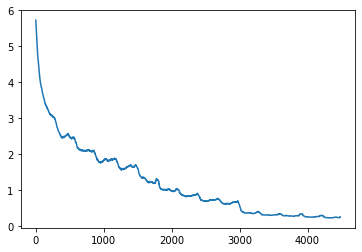

In [ ]:
losses += train(net, data2['train'], lr=0.01, epochs=15, start_epoch=10, checkpoint_path=dir)
plt.plot(smooth(losses,50))

In [ ]:
print("Training accuracy: %f" % accuracy(net, data2['train']))

Training accuracy: 0.978149


In [ ]:
predict(net, data2['test'], checkpoints + "preds6.csv")

### Adding dropout
I researched a bit and found that adding dropout may help to lower overfitting. Therefore, I added a dropout layer before the final linear layer. 

With the same schedule as previous, the training accuracy was 92.5% and kaggle was 67.6%.

[0,    10] loss: 6.788
[0,    20] loss: 6.388
[0,    30] loss: 6.125
[0,    40] loss: 5.783
[0,    50] loss: 5.404
[0,    60] loss: 5.211
[0,    70] loss: 5.124
[0,    80] loss: 4.992
[0,    90] loss: 4.789
[0,   100] loss: 4.656
[0,   110] loss: 4.605
[0,   120] loss: 4.378
[0,   130] loss: 4.339
[0,   140] loss: 4.397
[0,   150] loss: 4.237
[0,   160] loss: 4.197
[0,   170] loss: 4.143
[0,   180] loss: 4.028
[0,   190] loss: 4.085
[0,   200] loss: 4.083
[0,   210] loss: 3.884
[0,   220] loss: 3.984
[0,   230] loss: 3.782
[0,   240] loss: 3.772
[0,   250] loss: 3.806
[0,   260] loss: 3.884
[0,   270] loss: 3.798
[0,   280] loss: 3.777
[0,   290] loss: 3.760
[0,   300] loss: 3.672
[1,    10] loss: 3.865
[1,    20] loss: 3.817
[1,    30] loss: 3.707
[1,    40] loss: 3.590
[1,    50] loss: 3.610
[1,    60] loss: 3.515
[1,    70] loss: 3.452
[1,    80] loss: 3.382
[1,    90] loss: 3.382
[1,   100] loss: 3.341
[1,   110] loss: 3.311
[1,   120] loss: 3.326
[1,   130] loss: 3.294
[1,   140] 

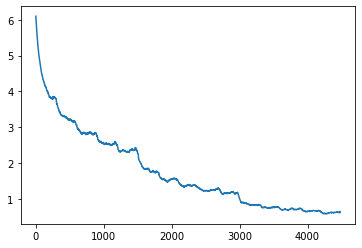

In [ ]:
dir = checkpoints + 'drop/'
if not os.path.exists(dir):
    os.makedirs(dir)

losses = train(net, data['train'], epochs=5, lr=0.03, checkpoint_path=dir)

data2 = get_data(224)
losses += train(net, data2['train'], epochs=10, start_epoch=5, lr=0.03, checkpoint_path=dir)
losses += train(net, data2['train'], epochs=15, start_epoch=10, lr=0.01, checkpoint_path=dir)
plt.plot(smooth(losses,50))

In [ ]:
print("Training accuracy: %f" % accuracy(net, data2['train']))
predict(net, data2['test'], checkpoints + "preds7.csv")

Training accuracy: 0.925157
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


The overfitting was a bit less, so I tried to train for another 5 epochs with lr=0.01. This one only resulted in 67.8% on kaggle. Not too much of an increase.

[15,    10] loss: 0.519
[15,    20] loss: 0.523
[15,    30] loss: 0.500
[15,    40] loss: 0.518
[15,    50] loss: 0.515
[15,    60] loss: 0.525
[15,    70] loss: 0.593
[15,    80] loss: 0.558
[15,    90] loss: 0.544
[15,   100] loss: 0.540
[15,   110] loss: 0.519
[15,   120] loss: 0.566
[15,   130] loss: 0.564
[15,   140] loss: 0.580
[15,   150] loss: 0.588
[15,   160] loss: 0.574
[15,   170] loss: 0.577
[15,   180] loss: 0.562
[15,   190] loss: 0.615
[15,   200] loss: 0.583
[15,   210] loss: 0.602
[15,   220] loss: 0.588
[15,   230] loss: 0.597
[15,   240] loss: 0.607
[15,   250] loss: 0.579
[15,   260] loss: 0.598
[15,   270] loss: 0.549
[15,   280] loss: 0.580
[15,   290] loss: 0.548
[15,   300] loss: 0.590
[16,    10] loss: 0.587
[16,    20] loss: 0.603
[16,    30] loss: 0.619
[16,    40] loss: 0.579
[16,    50] loss: 0.515
[16,    60] loss: 0.542
[16,    70] loss: 0.552
[16,    80] loss: 0.524
[16,    90] loss: 0.529
[16,   100] loss: 0.544
[16,   110] loss: 0.525
[16,   120] loss

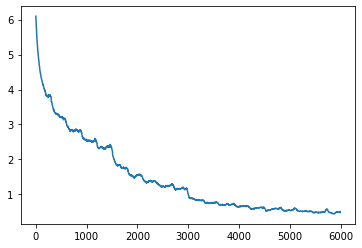

In [ ]:
losses += train(net, data2['train'], epochs=20, start_epoch=15, lr=0.01, checkpoint_path=dir)
plt.plot(smooth(losses,50))
print("Training accuracy: %f" % accuracy(net, data2['train']))
predict(net, data2['test'], checkpoints + "preds8.csv")

I was also curious to see what accuracy was like with the 128 pixel dataset instead. That one had 61.8% training accuracy which is surprisingly extremely worse than the 224 pixel dataset.

In [ ]:
print("Training accuracy: %f" % accuracy(net, data['train']))

Training accuracy: 0.618690


### Adding more weight decay
I know that decay can help reduce overfitting. Therefore, I tried doubling it and redoing the 5 epochs from above. Kaggle resulted in 67.3% which is not much of a difference (and actually 0.5% less).

In [ ]:
state = torch.load(checkpoints + 'drop/checkpoint-15.pkl')
net.load_state_dict(state['net'])

[15,    10] loss: 0.547
[15,    20] loss: 0.527
[15,    30] loss: 0.528
[15,    40] loss: 0.506
[15,    50] loss: 0.595
[15,    60] loss: 0.532
[15,    70] loss: 0.516
[15,    80] loss: 0.565
[15,    90] loss: 0.532
[15,   100] loss: 0.559
[15,   110] loss: 0.570
[15,   120] loss: 0.546
[15,   130] loss: 0.584
[15,   140] loss: 0.544
[15,   150] loss: 0.554
[15,   160] loss: 0.612
[15,   170] loss: 0.602
[15,   180] loss: 0.574
[15,   190] loss: 0.578
[15,   200] loss: 0.581
[15,   210] loss: 0.563
[15,   220] loss: 0.580
[15,   230] loss: 0.554
[15,   240] loss: 0.598
[15,   250] loss: 0.577
[15,   260] loss: 0.590
[15,   270] loss: 0.585
[15,   280] loss: 0.610
[15,   290] loss: 0.605
[15,   300] loss: 0.599
[16,    10] loss: 0.536
[16,    20] loss: 0.595
[16,    30] loss: 0.541
[16,    40] loss: 0.535
[16,    50] loss: 0.546
[16,    60] loss: 0.563
[16,    70] loss: 0.564
[16,    80] loss: 0.563
[16,    90] loss: 0.549
[16,   100] loss: 0.540
[16,   110] loss: 0.522
[16,   120] loss

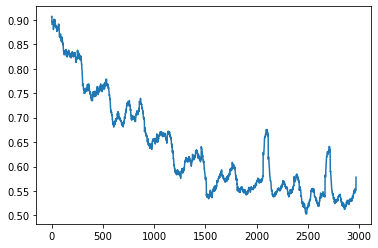

In [ ]:
dir = checkpoints + 'drop_wd/'
if not os.path.exists(dir):
    os.makedirs(dir)

losses = state['losses']
losses += train(net, data2['train'], epochs=20, start_epoch=15, lr=0.01, decay=0.001, checkpoint_path=dir)
plt.plot(smooth(losses,50))
print("Training accuracy: %f" % accuracy(net, data2['train']))
predict(net, data2['test'], checkpoints + "preds9.csv")

In [13]:
dir = checkpoints + 'drop/'
if not os.path.exists(dir):
    os.makedirs(dir)

state = torch.load(checkpoints + 'drop/checkpoint-20.pkl')
net.load_state_dict(state['net'])
losses = train(net, data2['train'], epochs=25, start_epoch=20, lr=0.01, checkpoint_path=dir)
print("Training accuracy: %f" % accuracy(net, data2['train']))


[20,    10] loss: 0.432
[20,    20] loss: 0.366
[20,    30] loss: 0.418
[20,    40] loss: 0.391
[20,    50] loss: 0.411
[20,    60] loss: 0.409
[20,    70] loss: 0.434
[20,    80] loss: 0.455
[20,    90] loss: 0.439
[20,   100] loss: 0.400
[20,   110] loss: 0.433
[20,   120] loss: 0.431
[20,   130] loss: 0.442
[20,   140] loss: 0.428
[20,   150] loss: 0.398
[20,   160] loss: 0.419
[20,   170] loss: 0.447
[20,   180] loss: 0.429
[20,   190] loss: 0.436
[20,   200] loss: 0.452
[20,   210] loss: 0.419
[20,   220] loss: 0.417
[20,   230] loss: 0.426
[20,   240] loss: 0.446
[20,   250] loss: 0.417
[20,   260] loss: 0.418
[20,   270] loss: 0.497
[20,   280] loss: 0.441
[20,   290] loss: 0.474
[20,   300] loss: 0.478
[21,    10] loss: 0.440
[21,    20] loss: 0.485
[21,    30] loss: 0.434
[21,    40] loss: 0.391
[21,    50] loss: 0.444
[21,    60] loss: 0.406
[21,    70] loss: 0.408
[21,    80] loss: 0.397
[21,    90] loss: 0.413
[21,   100] loss: 0.421
[21,   110] loss: 0.414
[21,   120] loss

In [ ]:
predict(net, data2['test'], checkpoints + "preds10.csv")

## Extra Data Augmentation
Another change I made was adding extra data augmentation. An image from the extra augmentation (top image) and from the previous augmentation (bottom image) can be seen below.

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [63]:
def get_data_train(size, extra_aug):
  if extra_aug :
    transform_train = transforms.Compose([
      transforms.ColorJitter(0.5, 0.5, 0.5, 0),
      transforms.RandomRotation(15),
      transforms.RandomCrop(size, padding=8, padding_mode='edge'),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ])
  else:
    transform_train = transforms.Compose([
      transforms.RandomCrop(size, padding=8, padding_mode='edge'),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ])

  trainset = torchvision.datasets.ImageFolder('./birds%d/train' % size, transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, num_workers=2)
  return trainloader

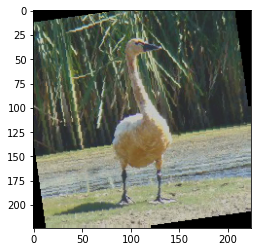

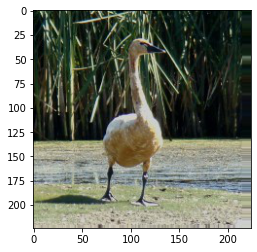

In [64]:
data_aug = get_data_train(224, True)
dataiter = iter(data_aug)
images, labels = dataiter.next()
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

data_no_aug = get_data_train(224, False)
dataiter = iter(data_no_aug)
images, labels = dataiter.next()
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

Here, I trained with the extra data augmentation and found that not only was the training accuracy lower, but the testing accuracy stayed fairly the same (66.9%). Although not seen here, the testing accuracy for training without color jitter actually was a bit better at 67.5%.

[0,    10] loss: 6.841
[0,    20] loss: 6.625
[0,    30] loss: 6.389
[0,    40] loss: 6.099
[0,    50] loss: 5.847
[0,    60] loss: 5.625
[0,    70] loss: 5.453
[0,    80] loss: 5.260
[0,    90] loss: 5.239
[0,   100] loss: 5.045
[0,   110] loss: 4.917
[0,   120] loss: 4.872
[0,   130] loss: 4.737
[0,   140] loss: 4.788
[0,   150] loss: 4.729
[0,   160] loss: 4.628
[0,   170] loss: 4.574
[0,   180] loss: 4.440
[0,   190] loss: 4.427
[0,   200] loss: 4.387
[0,   210] loss: 4.371
[0,   220] loss: 4.339
[0,   230] loss: 4.353
[0,   240] loss: 4.235
[0,   250] loss: 4.238
[0,   260] loss: 4.188
[0,   270] loss: 4.070
[0,   280] loss: 4.196
[0,   290] loss: 4.067
[0,   300] loss: 3.978
[1,    10] loss: 4.182
[1,    20] loss: 4.089
[1,    30] loss: 3.948
[1,    40] loss: 3.971
[1,    50] loss: 3.828
[1,    60] loss: 3.847
[1,    70] loss: 3.819
[1,    80] loss: 3.896
[1,    90] loss: 3.810
[1,   100] loss: 3.833
[1,   110] loss: 3.785
[1,   120] loss: 3.694
[1,   130] loss: 3.882
[1,   140] 

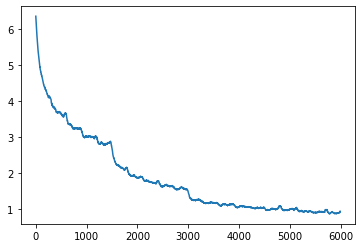

In [59]:
dir = checkpoints + 'drop_extra_aug_nohue/'
if not os.path.exists(dir):
    os.makedirs(dir)

data = get_data(128)
losses = train(net, data['train'], epochs=5, lr=0.03, checkpoint_path=dir)

data2 = get_data(224)
losses += train(net, data2['train'], epochs=10, start_epoch=5, lr=0.03, checkpoint_path=dir)
losses += train(net, data2['train'], epochs=20, start_epoch=10, lr=0.01, checkpoint_path=dir)
plt.plot(smooth(losses,50))
print("Training accuracy: %f" % accuracy(net, data2['train']))

In [ ]:
predict(net, data2['test'], checkpoints + "preds13.csv")

I trained the network another 5 epochs to see if it could improve. Instead, I found that the accuracy actually decreased to 66.5%. It seems that the network began to memorize the training data.

In [61]:
losses += train(net, data2['train'], epochs=25, start_epoch=20, lr=0.01, checkpoint_path=dir)
print("Training accuracy: %f" % accuracy(net, data2['train']))

[20,    10] loss: 0.838
[20,    20] loss: 0.811
[20,    30] loss: 0.875
[20,    40] loss: 0.861
[20,    50] loss: 0.834
[20,    60] loss: 0.865
[20,    70] loss: 0.872
[20,    80] loss: 0.849
[20,    90] loss: 0.822
[20,   100] loss: 0.805
[20,   110] loss: 0.838
[20,   120] loss: 0.842
[20,   130] loss: 0.820
[20,   140] loss: 0.880
[20,   150] loss: 0.857
[20,   160] loss: 0.815
[20,   170] loss: 0.830
[20,   180] loss: 0.868
[20,   190] loss: 0.889
[20,   200] loss: 0.860
[20,   210] loss: 0.952
[20,   220] loss: 0.867
[20,   230] loss: 0.933
[20,   240] loss: 0.849
[20,   250] loss: 0.893
[20,   260] loss: 0.904
[20,   270] loss: 0.914
[20,   280] loss: 0.909
[20,   290] loss: 0.893
[20,   300] loss: 0.885
[21,    10] loss: 0.839
[21,    20] loss: 0.852
[21,    30] loss: 0.871
[21,    40] loss: 0.795
[21,    50] loss: 0.869
[21,    60] loss: 0.795
[21,    70] loss: 0.813
[21,    80] loss: 0.790
[21,    90] loss: 0.830
[21,   100] loss: 0.817
[21,   110] loss: 0.912
[21,   120] loss

In [ ]:
predict(net, data2['test'], checkpoints + "preds14.csv")

Here is the training accuracy for the model without color jitter after 20 epochs. The testing accuracy was 67.5%.

In [9]:
def get_data(size):
  transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomCrop(size, padding=8, padding_mode='edge'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  trainset = torchvision.datasets.ImageFolder('./birds%d/train' % size, transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder('./birds%d/test' % size, transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=2)

  class_to_idx = trainset.class_to_idx
  idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
  return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class}

In [10]:
state = torch.load(checkpoints + 'drop_aug/checkpoint-20.pkl')
net.load_state_dict(state['net'])
data2 = get_data(224)
print("Training accuracy: %f" % accuracy(net, data2['train']))

Training accuracy: 0.902735


After this, I tried out all epochs between the 20th and 25th to find the one with the best testing accuracy.

In [ ]:
for i in range(21, 25):
  state = torch.load(checkpoints + 'drop_aug/checkpoint-' + str(i) + '.pkl')
  net.load_state_dict(state['net'])
  predict(net, data2['test'], checkpoints + "preds" + str(i) + "aug.csv")

In [ ]:
for i in range(21, 23):
  state = torch.load(checkpoints + 'drop_extra_aug_nohue/checkpoint-' + str(i) + '.pkl')
  net.load_state_dict(state['net'])
  predict(net, data2['test'], checkpoints + "preds" + str(i) + "extraaug.csv")